# Exam 03

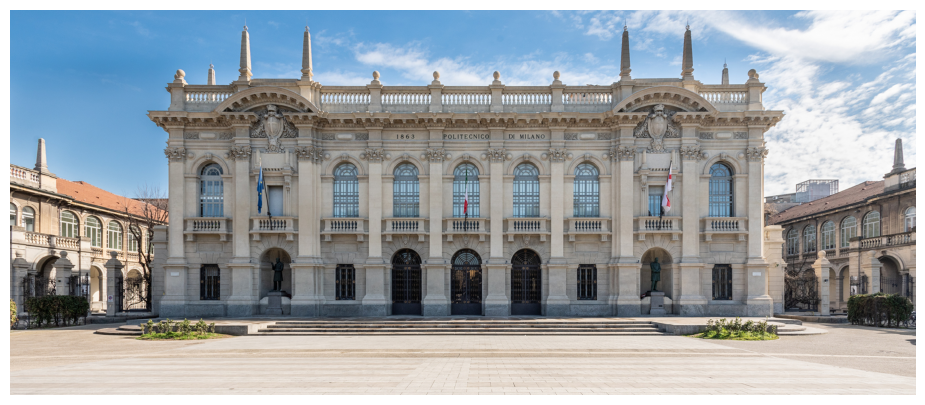

In [4]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.image import imread

image_path = 'polimi_compressed.jpg'
img = imread(image_path)
img_RGB = [np.array(img[:,:,i], dtype = np.float64)/255 for i in range(3)]
def plot_image(RGB, ax = None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize = (12,5))
    ax.imshow(np.clip(np.stack(RGB, axis = 2),0,1))
    plt.axis('off')
plot_image(img_RGB)
# Now, randomly replace 70% of the pixels with random colors.
damage_fraction = 0.7
np.random.seed(0)
mask_remove = np.random.choice(a=[True, False], size=(img.shape[0],img.shape[1]), p=[damage_fraction, 1-damage_fraction])
mask_keep = np.logical_not(mask_remove)
img_damaged_RGB = [img_RGB[i].copy() for i in range(3)]
for i in range(3):
    img_damaged_RGB[i][mask_remove] = np.random.rand(np.sum(mask_remove))


(816, 1920)
(816, 1920)
(816, 1920)


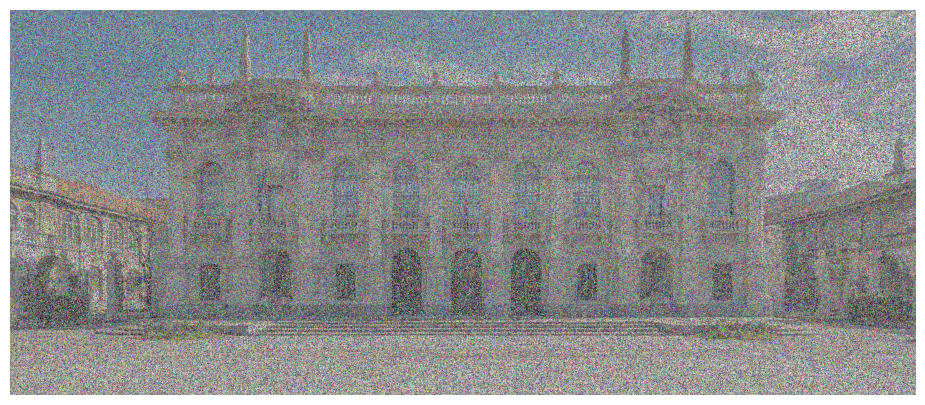

In [27]:
print(img_damaged_RGB[0].shape)
print(img_damaged_RGB[1].shape)
print(img_damaged_RGB[2].shape)

plot_image(img_damaged_RGB)

In [32]:
RMSE_list = list()
rho_list = list()

def svt(X, threshold, tollerance,  mask_keep, n_max_iter= 1000, X_true = None):
    A = X.copy() # create a copy of the input matrix that we will modify
    A[np.logical_not(mask_keep)] = 0 # set to zero the unknown values
    
    for i in range(n_max_iter):
        A_old = A.copy()
        U,s,VT = np.linalg.svd(A, full_matrices = False)

        # threshold the singular values
        s[s < threshold] = 0
        A = U @ np.diag(s) @ VT # reconstruct the matrix

        A[mask_keep] = X[mask_keep] # impose the known values
        increment = np.linalg.norm(A - A_old) # compute the increment

        # check if the increment is smaller than the tollerance
        if increment < tollerance:
            return A

        ### OPTIONAL - COMPUTE THE ERROR ACCORDING TO THE MATRIX WE WANT TO APPROXIMATE
        if X_true is not None:
            RMSE_list.append(np.sqrt(np.mean((X_true-A)**2)))
            rho_list.append(pearsonr(X_true.flatten(),A.flatten())[0])
            print('=============== Iteration %d - increment norm %1.3e' % (i+1, increment))
            print('RMSE: %1.3f' % RMSE_list[-1])
            print('rho:  %1.3f' % rho_list[-1])
    return A


In [37]:
img_svt_reconstructed = np.array([svt(img_damaged_RGB[i], 500, 1e-3, mask_keep, n_max_iter=20) for i in range(3)])

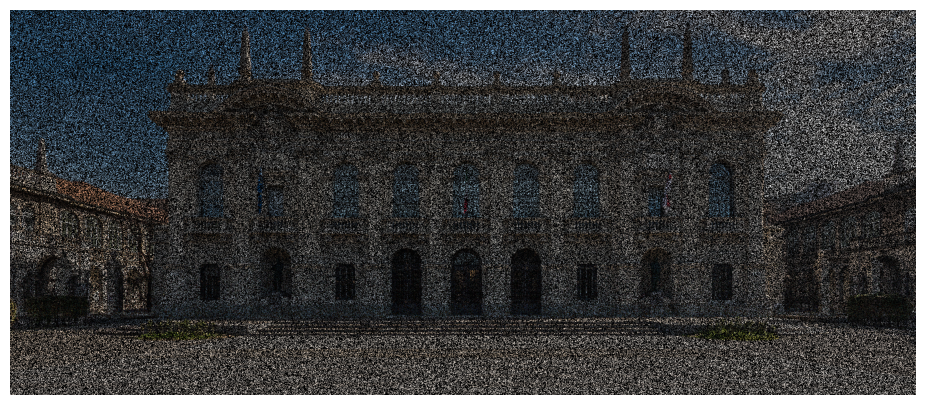

In [36]:
plot_image(img_RGB - img_svt_reconstructed)
img_cp = img_RGB.copy()
img_cp[0][mask_remove] = 0
img_cp[1][mask_remove] = 0
img_cp[2][mask_remove] = 0
plot_image(img_cp)
plot_image(img_svt_reconstructed)

## Exercise 02


A perceptron is a very simple ANN composed of a single neuron and a single layer, taking in multiple inputs which are then weighted and pased through an activation function.

$\mathbf{y} = \sigma (\mathbf{w} \cdot \mathbf{x} + \mathbf{b} ) $

So to update the parameters we simply apply gradient descent on the ANN

In [12]:
x = np.array([[2, -1], [-1, 1], [2, 0.5], [0.2, -0.2], [0.5, -1], [2, 1]])
y = np.array([1, 0, 1, 0, 1, 0])

plt.scatter(x[y==0,0], x[y==0,1], c = 'r', label = 'class 0')
plt.scatter(x[y==1,0], x[y==1,1], c = 'b', label = 'class 1')
plt.plot([2, 0.5], [1, -1])

x_l = np.linspace(-1, 1, 200)
y_l = 4/3*x_l - 5/3

plt.plot(x_l, y_l, label = 'decision boundary')


$\mathbf{y} = \sigma (\mathbf{w} \cdot \mathbf{x} + \mathbf{b} ) $

In this case the points above the line are the 0s and below are the ones, so we can identify a function to separate the two classes as  $ (\mathbf{x} \cdot \mathbf{w} + \mathbf{b}) \ge 0 => y = 0$

The easiset function that can implement it is $ \sigma(z) = (1 - step(z))$

In [174]:
import jax
from jax import numpy as jnp

classification = lambda p : jnp.heaviside(p, 0)
# activation = lambda z: (1 - jnp.tanh(z, 0))
# activation = lambda z: jnp.tanh(z)
activation = lambda z: z

def ANN(x, w, b):
    return activation(x @ w + b)

In [185]:
def loss(w, b, x, y):
    # hinge loss
    return jnp.mean(jnp.maximum(0, 1 - (2*y-1)*(2*ANN(x, w, b)-1)))

(2,)
(6, 2)
(1,)
[1 0 1 0 1 0]
[ 2.  -1.   2.   0.2  0.5  2. ]
[ 2.  -1.   2.   0.2  0.5  2. ]
(6,)
(Array([0.56666666, 0.6       ], dtype=float32), Array([0.33333334], dtype=float32))
(Array([0.56666666, 0.6       ], dtype=float32), Array([0.33333334], dtype=float32))
(Array([-0.8333334 ,  0.16666667], dtype=float32), Array([-0.6666667], dtype=float32))
(Array([0.73333335, 0.26666668], dtype=float32), Array([0.6666667], dtype=float32))
(Array([-0.8333334 ,  0.16666667], dtype=float32), Array([-0.6666667], dtype=float32))
(Array([0.73333335, 0.26666668], dtype=float32), Array([0.6666667], dtype=float32))
(Array([-0.8333334 ,  0.16666667], dtype=float32), Array([-0.6666667], dtype=float32))
(Array([0.73333335, 0.26666668], dtype=float32), Array([0.6666667], dtype=float32))
(Array([-0.6       , -0.23333333], dtype=float32), Array([0.], dtype=float32))
(Array([0.06666666, 0.10000001], dtype=float32), Array([0.33333334], dtype=float32))
(Array([0.        , 0.16666667], dtype=float32), Arra

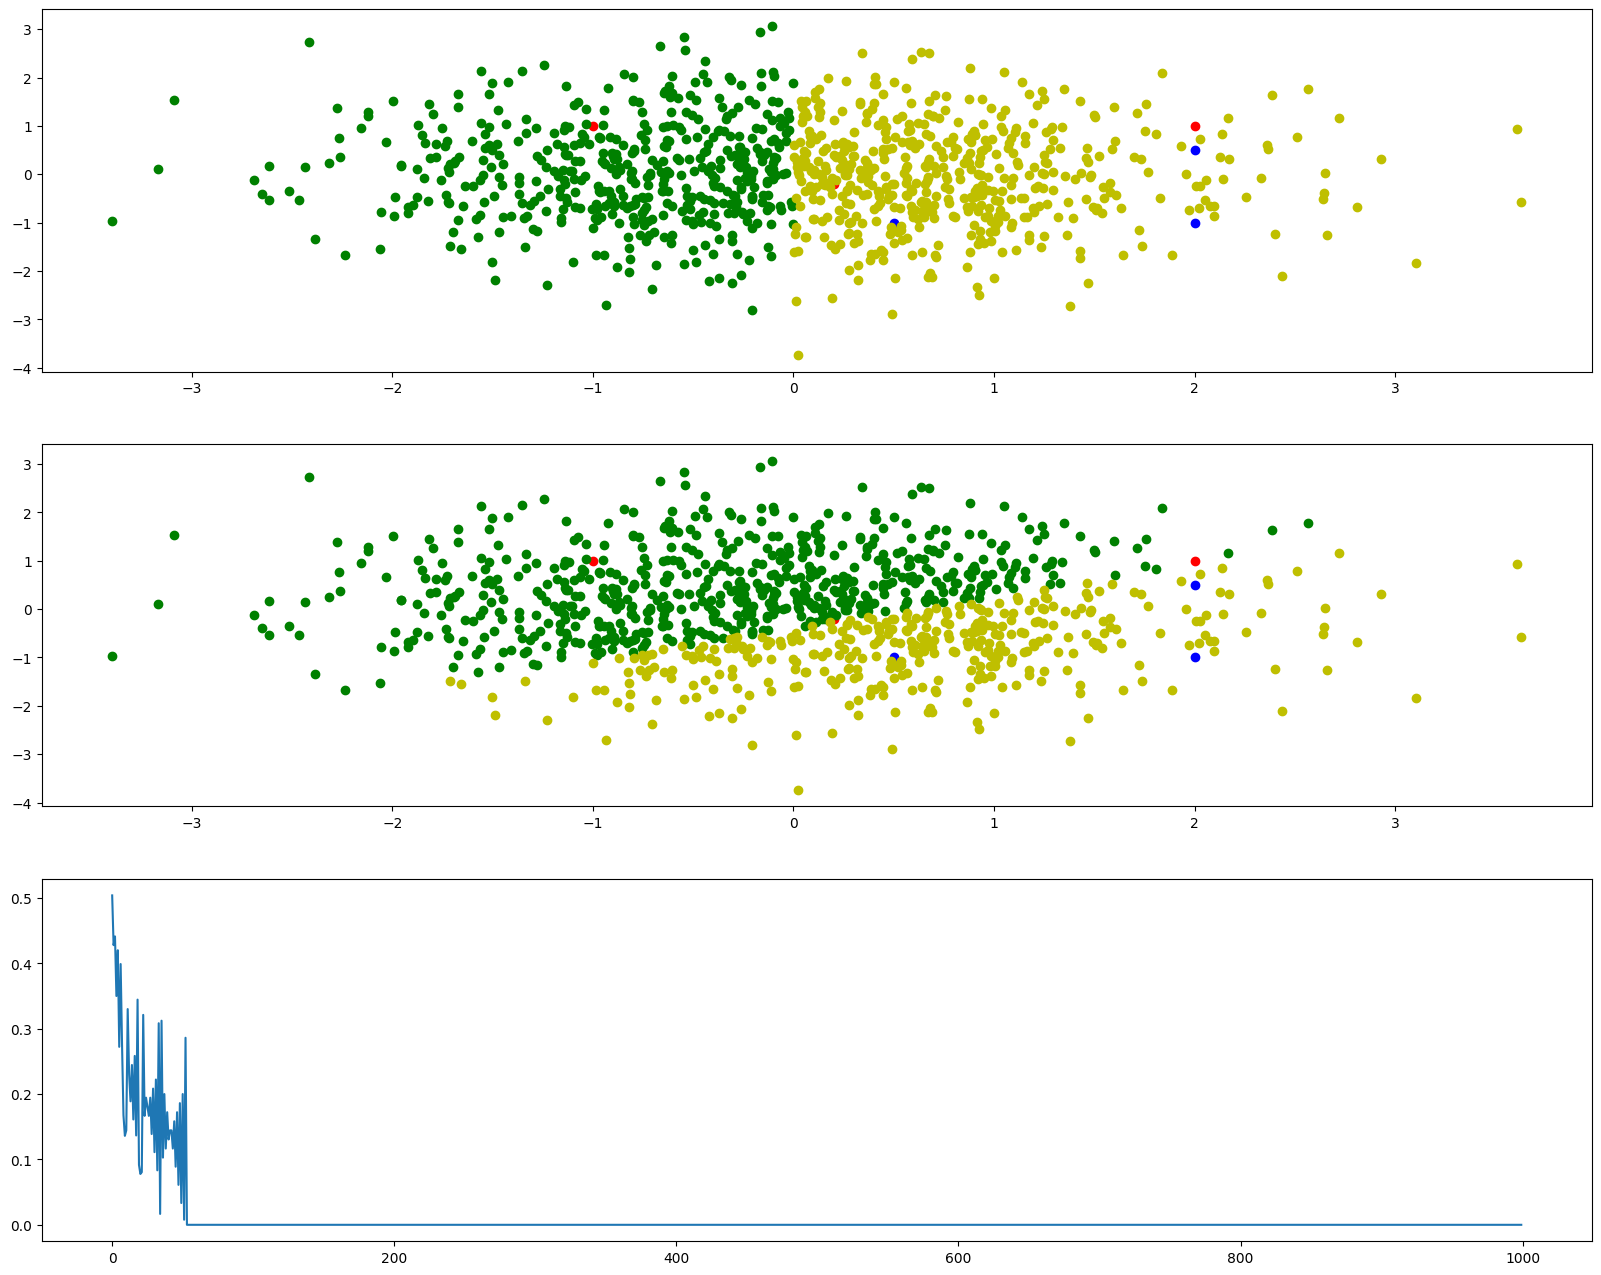

In [187]:
epoch = 1000
learning_rate = 0.5
w0 = jnp.array([1.0, 0.0])
b0 = jnp.array([0.0])

x = np.array([[2, -1], [-1, 1], [2, 0.5], [0.2, -0.2], [0.5, -1], [2, 1]])
y = np.array([1, 0, 1, 0, 1, 0])

loss_jit = jax.jit(loss)
grad_loss = jax.jit(jax.grad(loss, argnums=(0, 1)))

fig, ax = plt.subplots(3,1, figsize = (20,16))
ax = ax.flatten()

x_test = np.random.randn(1000, 2)

ax[0].scatter(x[y==0,0], x[y==0,1], c = 'r', label = 'class 0')
ax[0].scatter(x[y==1,0], x[y==1,1], c = 'b', label = 'class 1')

y0 = classification(ANN(x_test, w0, b0))
ax[0].scatter(x_test[y0==0,0], x_test[y0==0,1], c = 'g')
ax[0].scatter(x_test[y0==1,0], x_test[y0==1,1], c = 'y')

w, b = w0, b0

print(w.shape)
print(x.shape)
print(b.shape)
print(y)
print(x @ w + b)
print(ANN(x, w, b))
print(y.shape)

loss_history = list()
for i in range(epoch):
    grads = grad_loss(w, b, x, y)
    w -= learning_rate * grads[0]
    b -= learning_rate * grads[1]
    print(grads)
    #print(loss_jit(w, b, x, y))
    loss_history.append(loss_jit(w, b, x, y))

ax[1].scatter(x[y==0,0], x[y==0,1], c = 'r', label = 'class 0')
ax[1].scatter(x[y==1,0], x[y==1,1], c = 'b', label = 'class 1')

print(x @ w + b)
print(ANN(x, w, b))

yn = classification(ANN(x_test, w, b))
ax[1].scatter(x_test[yn==0,0], x_test[yn==0,1], c = 'g')
ax[1].scatter(x_test[yn==1,0], x_test[yn==1,1], c = 'y')

ax[2].plot(loss_history)

## Exercise 03

In [196]:
a = np.array([1.0, 2.0, 3.0])
c = 2.0
k = 1

yk = jnp.exp(a[k])/jnp.sum(jnp.exp(a))
yk_t = jnp.exp(a[k]+c)/jnp.sum(jnp.exp(a+c))

print(yk, yk_t, yk_t-yk)

0.24472848 0.24472846 -1.4901161e-08
